In [2]:
"""
Heart Disease Prediction Model - LogisticRegression with FastAPI Backend
"""

# 1. Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc


In [3]:
# load the dataset
def load_data(path):
    """Load heart disease dataset"""
    try:
        # If using kagglehub
        import kagglehub

        path = kagglehub.dataset_download("johnsmith88/heart-disease-dataset")
        df = pd.read_csv(path + "/heart.csv")
    except:
        # Fallback if direct path is provided or kagglehub fails
        df = pd.read_csv("heart.csv" if path is None else path)
    return df

In [4]:
# Data preprocessing
def preprocess_data(df):
    """Preprocess the data"""
    # Check for null values and duplicates
    print("Null values:", df.isnull().sum().sum())
    print("Original shape:", df.shape)

    # Remove duplicates
    df = df.drop_duplicates()
    print("Shape after removing duplicates:", df.shape)

    # Exploratory data analysis (basic)
    print("\nData Description:")
    print(df.describe())

    # Feature selection
    X = df.drop(columns=["target"], axis=1)
    y = df["target"]

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, X.columns.tolist()

In [5]:
# Model Training and Evaluation
def train_model(X_train, y_train, X_test, y_test):
    """Train LogisticRegression model and evaluate performance"""
    # Train the model with hyperparameter tuning
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000]
    }
    
    grid_search = GridSearchCV(
        LogisticRegression(random_state=42),
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    # Get best model
    best_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    
    # Evaluate on test data
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Disease', 'Disease'],
                yticklabels=['No Disease', 'Disease'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    
    # Feature importance
    coef_df = pd.DataFrame({
        'Feature': X_columns,
        'Coefficient': best_model.coef_[0]
    })
    coef_df['Abs_Coefficient'] = abs(coef_df['Coefficient'])
    coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Coefficient', y='Feature', data=coef_df)
    plt.title('Feature Importance (Logistic Regression Coefficients)')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    
    return best_model


In [6]:
#  Export model
def export_model(model, scaler, columns):
    """Export the trained model and scaler for use in FastAPI"""
    if not os.path.exists("models"):
        os.makedirs("models")

    # Save model
    with open("models/logistic_model.pkl", "wb") as f:
        pickle.dump(model, f)

    # Save scaler
    with open("models/scaler.pkl", "wb") as f:
        pickle.dump(scaler, f)

    # Save feature columns
    with open("models/features.pkl", "wb") as f:
        pickle.dump(columns, f)

    print("Model and preprocessing objects exported to 'models/' directory")

c:\AI_ML\HeartCare\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Null values: 0
Original shape: (1025, 14)
Shape after removing duplicates: (302, 14)

Data Description:
             age         sex          cp    trestbps        chol         fbs  \
count  302.00000  302.000000  302.000000  302.000000  302.000000  302.000000   
mean    54.42053    0.682119    0.963576  131.602649  246.500000    0.149007   
std      9.04797    0.466426    1.032044   17.563394   51.753489    0.356686   
min     29.00000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     48.00000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     55.50000    1.000000    1.000000  130.000000  240.500000    0.000000   
75%     61.00000    1.000000    2.000000  140.000000  274.750000    0.000000   
max     77.00000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  302.000000  302.000000  302.000000  302.000000  302.000000  302.000000   
mean     0.52

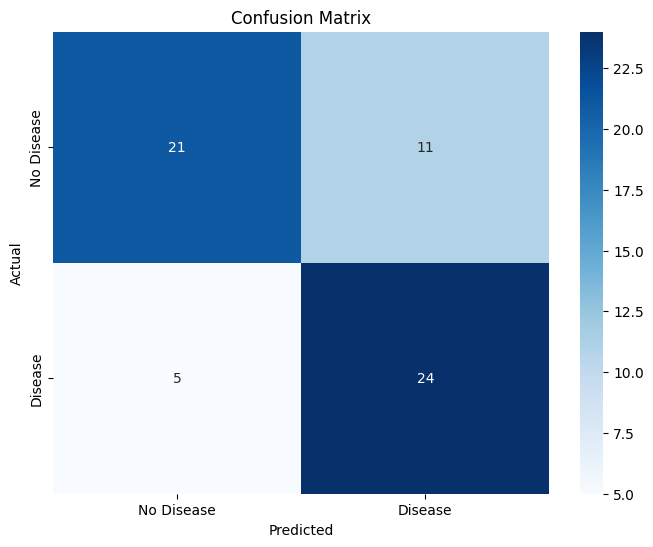

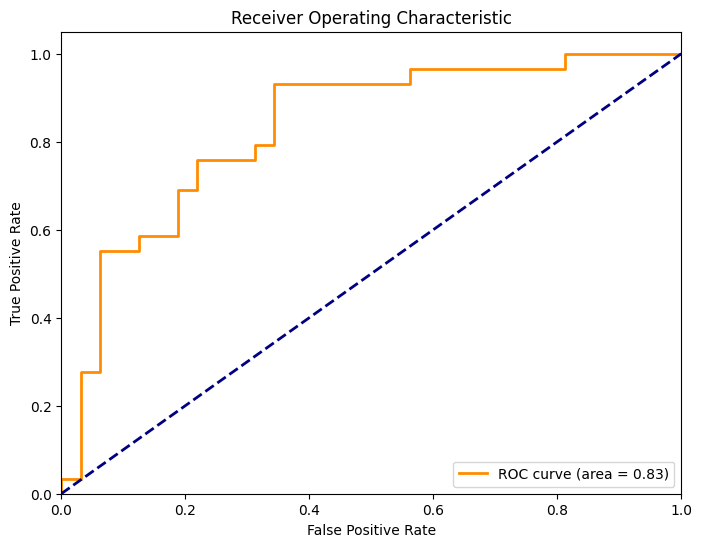

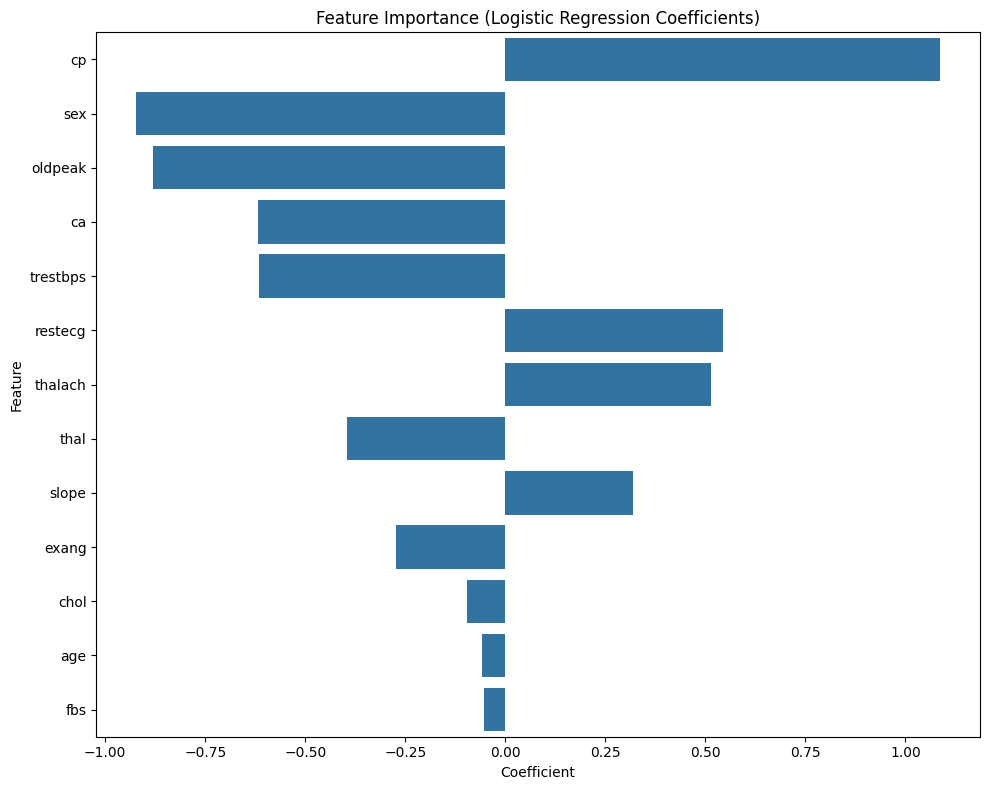

In [7]:
# Load data
df = load_data(None)  # Replace None with your path if needed

# Preprocess data
X_train_scaled, X_test_scaled, y_train, y_test, scaler, X_columns = preprocess_data(df)

# Train and evaluate model
model = train_model(X_train_scaled, y_train, X_test_scaled, y_test)

# Export model
export_model(model, scaler, X_columns)